### NNet Ratio

In [1]:
# import Ratio
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
from Ratio import *

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.distributions as dist
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torchsummary import summary
import numpy as np
import scipy.stats as scs
from statsmodels.distributions.empirical_distribution import ECDF
import time
import ot
from pyhmc import hmc


c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [48]:
# load airquality dataset
from ucimlrepo import fetch_ucirepo
import numpy as np

# fetch dataset
air_quality = fetch_ucirepo(id=360)
# data (as pandas dataframes)
X = air_quality.data.features.to_numpy()
# only the numeric variables
X = X[:,2:]
# Check the shapes of X and y
print("Shape of X:", X.shape)
X = np.vectorize(pd.to_numeric)(X)

Shape of X: (9357, 13)


In [49]:
MAGIC_data = X + np.random.normal(X.shape[0],X.shape[1])


In [34]:

# Load the data from the CSV file
MAGIC_data = pd.read_csv('magic.csv')
MAGIC_data = MAGIC_data[MAGIC_data.iloc[:, -1] == 'g']
selected_columns = ['fLength', 'Width', 'fConc', 'fM3Long', 'fM3Trans']
MAGIC_data = np.array(MAGIC_data[selected_columns])

torch.manual_seed(990109)
np.random.seed(990109)

seed = 990109

n_indep = 10

In [50]:
import numpy as np

# Check if all elements in MAGIC_data are numeric
is_numeric = np.issubdtype(MAGIC_data.dtype, np.number)

if is_numeric:
    print("All elements in MAGIC_data are numeric.")
else:
    print("MAGIC_data contains non-numeric elements.")

All elements in MAGIC_data are numeric.


In [5]:
MAGIC_data.shape

(12332, 5)

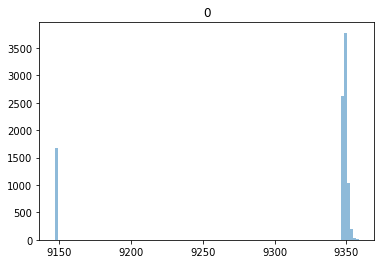

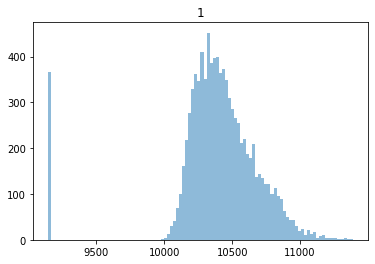

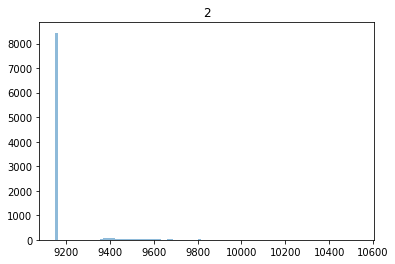

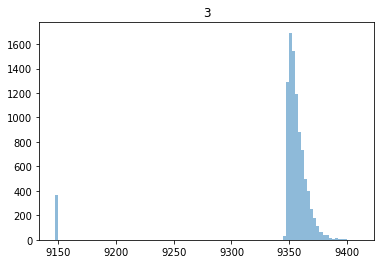

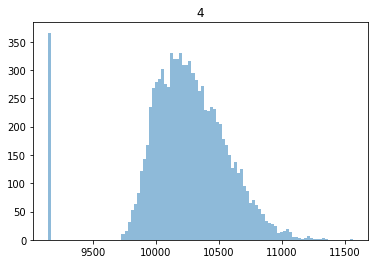

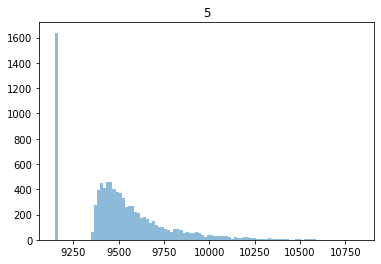

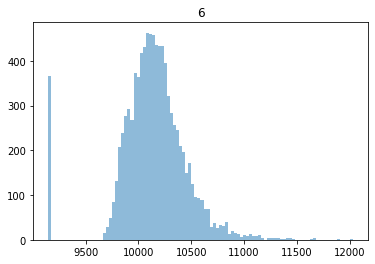

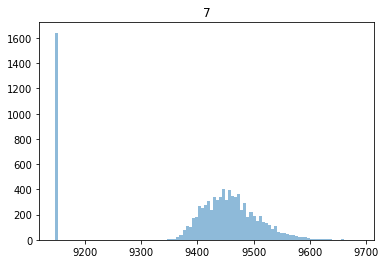

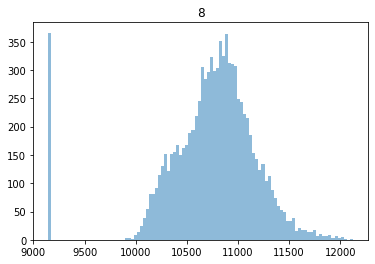

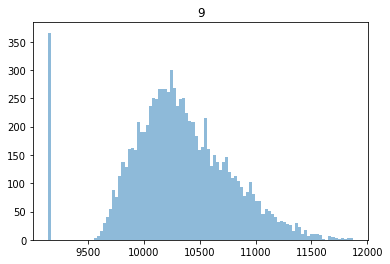

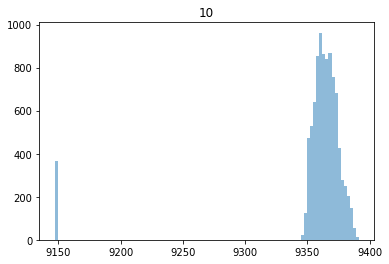

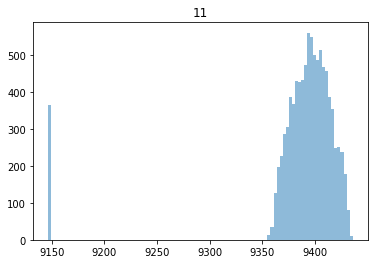

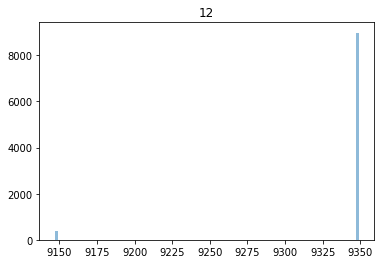

In [65]:
import matplotlib.pyplot as plt
for k in range(len(MAGIC_data[0])):
    plt.hist(MAGIC_data[:,k], bins=100, alpha=0.5)
    plt.title(k)
    plt.show()

In [51]:
# Apply ECDF transformation
X_ecdf = np.zeros_like(MAGIC_data)
ecdf_list = []
for dim in range((MAGIC_data.shape[1])):
    ecdf = ECDF(MAGIC_data[:, dim])
    ecdf_list.append(ecdf)
    X_ecdf[:, dim] = np.clip(ecdf(MAGIC_data[:, dim]), 1e-6, 1 - 1e-6)

# Apply inverse of standard normal CDF (ppf)
X_gaussian = scs.norm.ppf(X_ecdf)
y_gaussian = torch.ones(X_gaussian.shape[0], dtype=torch.long)
# Convert to PyTorch tensors
X_gaussian = torch.tensor(X_gaussian, dtype=torch.float32)
# Split the data into training and testing sets (50/50 split)
X_train, X_test, y_train, y_test = train_test_split(X_gaussian, y_gaussian, test_size=0.5, random_state=seed)
# Create TensorDataset objects
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False)

In [52]:
MAGIC_data.shape[0]

9357

In [53]:
from tqdm import tqdm

In [114]:
train_ratio_model = True



if train_ratio_model:
    # Define model
    ratio_model = Ratio(h_dim=100, in_dim=MAGIC_data.shape[1], h_layers=2, normalising_cst = True, c = 1.0)

    # training loop for ####  GG Ratio  ####

    # Define loss function and optimizer
    optimizer = torch.optim.Adam(ratio_model.parameters())
    
    n_indep = 30
    num_epochs = 500

    GG_cov = np.cov(X_train.reshape(-1,MAGIC_data.shape[1]).T)

    for epoch in tqdm(range(num_epochs)):
        ratio_model.train()
        running_loss = 0.0
        noise_index = 0 
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            r_p = ratio_model(inputs).squeeze()
            r_q = ratio_model(torch.tensor(scs.multivariate_normal.rvs(mean=np.zeros(MAGIC_data.shape[1]), cov=GG_cov, size=n_indep*inputs.shape[0])).float()).squeeze()
            noise_index += inputs.shape[0]
            loss = loss_nce(r_p, r_q,inputs.shape[0], n_indep*inputs.shape[0])
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, c: {ratio_model.c.item()}")
            # if loss is nan
            if torch.isnan(loss):
                print("Loss is NaN. Exiting training.")
                break

            else:# save the model
                filename = f'GGNNet_air_qual_seed_.pth'
                torch.save(ratio_model.state_dict(), filename)
            
    
filename = f'GGNNet_air_qual_seed_.pth'
ratio_model = Ratio(h_dim=100, in_dim=MAGIC_data.shape[1], h_layers=2, normalising_cst = True, c = 1.0)
ratio_model.load_state_dict(torch.load(filename))

ratio_model.eval()


  2%|▏         | 10/500 [00:10<07:48,  1.05it/s]

Epoch 10/500, Loss: 0.00337714312869745, c: 1.0218498706817627


  4%|▍         | 20/500 [00:19<07:10,  1.12it/s]

Epoch 20/500, Loss: 0.0010220072920977448, c: 1.0195722579956055


  6%|▌         | 30/500 [00:28<07:07,  1.10it/s]

Epoch 30/500, Loss: 0.0005007455741482166, c: 1.0186572074890137


  8%|▊         | 40/500 [00:38<07:17,  1.05it/s]

Epoch 40/500, Loss: 0.00036076115308484685, c: 1.0178340673446655


 10%|█         | 50/500 [00:47<06:48,  1.10it/s]

Epoch 50/500, Loss: 0.00017360429046675563, c: 1.0172420740127563


 12%|█▏        | 60/500 [00:56<06:59,  1.05it/s]

Epoch 60/500, Loss: 0.00046700142714447185, c: 1.0168980360031128


 14%|█▍        | 70/500 [01:05<06:29,  1.10it/s]

Epoch 70/500, Loss: 0.0001989897418752662, c: 1.0164676904678345


 16%|█▌        | 80/500 [01:15<06:17,  1.11it/s]

Epoch 80/500, Loss: 0.00017383781232638285, c: 1.0155850648880005


 18%|█▊        | 90/500 [01:24<06:17,  1.09it/s]

Epoch 90/500, Loss: 0.00025076684232772095, c: 1.0148427486419678


 20%|██        | 100/500 [01:33<06:15,  1.07it/s]

Epoch 100/500, Loss: 0.00020487726177028284, c: 1.0142910480499268


 22%|██▏       | 110/500 [01:42<06:01,  1.08it/s]

Epoch 110/500, Loss: 4.8699219102369774e-05, c: 1.012416958808899


 24%|██▍       | 120/500 [01:51<05:47,  1.09it/s]

Epoch 120/500, Loss: 1.645009376716189e-05, c: 1.0127630233764648


 26%|██▌       | 130/500 [02:00<05:35,  1.10it/s]

Epoch 130/500, Loss: 3.429743105698435e-05, c: 1.0124694108963013


 28%|██▊       | 140/500 [02:09<05:19,  1.13it/s]

Epoch 140/500, Loss: 9.356986871959332e-05, c: 1.011981725692749


 30%|███       | 150/500 [02:19<05:31,  1.06it/s]

Epoch 150/500, Loss: 7.819170927329348e-05, c: 1.0105308294296265


 32%|███▏      | 160/500 [02:28<05:22,  1.05it/s]

Epoch 160/500, Loss: 0.00010232523374990403, c: 1.0103347301483154


 34%|███▍      | 170/500 [02:37<05:03,  1.09it/s]

Epoch 170/500, Loss: 0.00014934985444862528, c: 1.008953332901001


 36%|███▌      | 180/500 [02:49<05:57,  1.12s/it]

Epoch 180/500, Loss: 0.00023013995454827332, c: 1.0077979564666748


 38%|███▊      | 190/500 [03:00<05:14,  1.02s/it]

Epoch 190/500, Loss: 2.9741042718948545e-05, c: 1.0074193477630615


 40%|████      | 200/500 [03:12<05:40,  1.14s/it]

Epoch 200/500, Loss: 6.050425762775073e-06, c: 1.0077272653579712


 42%|████▏     | 210/500 [03:22<04:51,  1.00s/it]

Epoch 210/500, Loss: 0.0007147147919871107, c: 1.0069589614868164


 44%|████▍     | 220/500 [03:33<04:44,  1.02s/it]

Epoch 220/500, Loss: 8.520002997632522e-06, c: 1.0065624713897705


 46%|████▌     | 230/500 [03:43<04:20,  1.03it/s]

Epoch 230/500, Loss: 7.686316256657241e-06, c: 1.006919026374817


 48%|████▊     | 240/500 [03:53<04:15,  1.02it/s]

Epoch 240/500, Loss: 0.001052390857593603, c: 1.0029157400131226


 50%|█████     | 250/500 [04:02<03:45,  1.11it/s]

Epoch 250/500, Loss: 1.6243316020828995e-05, c: 1.0030632019042969


 52%|█████▏    | 260/500 [04:12<04:11,  1.05s/it]

Epoch 260/500, Loss: 5.536382791622903e-06, c: 1.0017377138137817


 54%|█████▍    | 270/500 [04:22<03:44,  1.02it/s]

Epoch 270/500, Loss: 2.3300208293145865e-06, c: 1.0024687051773071


 56%|█████▌    | 280/500 [04:33<03:56,  1.08s/it]

Epoch 280/500, Loss: 2.6582059836262792e-06, c: 1.0020877122879028


 58%|█████▊    | 290/500 [04:43<03:37,  1.03s/it]

Epoch 290/500, Loss: 1.5963453942428412e-06, c: 1.0026447772979736


 60%|██████    | 300/500 [04:53<03:06,  1.07it/s]

Epoch 300/500, Loss: 1.53315480844185e-06, c: 1.002954363822937


 62%|██████▏   | 310/500 [05:02<02:54,  1.09it/s]

Epoch 310/500, Loss: 4.882365464216794e-06, c: 1.0030235052108765


 64%|██████▍   | 320/500 [05:12<02:44,  1.10it/s]

Epoch 320/500, Loss: 1.0160512620889979e-06, c: 1.0031135082244873


 66%|██████▌   | 330/500 [05:21<02:31,  1.12it/s]

Epoch 330/500, Loss: 2.52909632673474e-06, c: 1.0033766031265259


 68%|██████▊   | 340/500 [05:31<02:31,  1.05it/s]

Epoch 340/500, Loss: 8.349273024066406e-07, c: 1.0032225847244263


 70%|███████   | 350/500 [05:40<02:21,  1.06it/s]

Epoch 350/500, Loss: 5.790864759565769e-07, c: 1.0036344528198242


 72%|███████▏  | 360/500 [05:50<02:08,  1.09it/s]

Epoch 360/500, Loss: 4.391346143014137e-07, c: 1.003926157951355


 74%|███████▍  | 370/500 [06:00<02:23,  1.10s/it]

Epoch 370/500, Loss: 4.3489057569937967e-07, c: 1.0039660930633545


 76%|███████▌  | 380/500 [06:11<01:59,  1.00it/s]

Epoch 380/500, Loss: 2.768612462252425e-07, c: 1.004271388053894


 78%|███████▊  | 390/500 [06:22<02:03,  1.12s/it]

Epoch 390/500, Loss: 3.49934779819705e-07, c: 1.0039933919906616


 80%|████████  | 400/500 [06:33<01:48,  1.08s/it]

Epoch 400/500, Loss: 2.3967399265245604e-07, c: 1.004262924194336


 82%|████████▏ | 410/500 [06:42<01:24,  1.07it/s]

Epoch 410/500, Loss: 2.355434093696355e-07, c: 1.0042359828948975


 84%|████████▍ | 420/500 [06:52<01:24,  1.05s/it]

Epoch 420/500, Loss: 4.2845199417958685e-07, c: 1.0041524171829224


 86%|████████▌ | 430/500 [07:02<01:07,  1.03it/s]

Epoch 430/500, Loss: 3.450451110017146e-07, c: 1.0039217472076416


 88%|████████▊ | 440/500 [07:12<00:56,  1.06it/s]

Epoch 440/500, Loss: 1.6592418357793312e-07, c: 1.0043349266052246


 90%|████████▉ | 449/500 [07:21<00:50,  1.02it/s]

Epoch 450/500, Loss: nan, c: nan
Loss is NaN. Exiting training.


NameError: name 'Ratio_Simple' is not defined

In [115]:
filename = f'GGNNet_air_qual_seed_.pth'
ratio_model = Ratio(h_dim=100, in_dim=MAGIC_data.shape[1], h_layers=2, normalising_cst = True, c = 1.0)
ratio_model.load_state_dict(torch.load(filename))

ratio_model.eval()

Ratio(
  (fc_in): Linear(in_features=13, out_features=100, bias=True)
  (fc_hidden): Linear(in_features=100, out_features=100, bias=True)
  (fc_out): Linear(in_features=100, out_features=1, bias=True)
)

In [116]:
# LL computation

ratio_model.eval()
X_train_flat = X_train.reshape(-1, MAGIC_data.shape[1])
X_test_flat = X_test.reshape(-1, MAGIC_data.shape[1])
GG_cov = np.cov(X_train_flat.T)
# Define the multivariate normal distribution with the given covariance matrix
GG_cov_tensor = torch.tensor(GG_cov, dtype=torch.float32)
multivariate_normal = dist.MultivariateNormal(loc=torch.zeros(MAGIC_data.shape[1]), covariance_matrix=GG_cov_tensor)
# Define the standard normal distribution
standard_normal = dist.Normal(loc=0, scale=1)
# Compute logpdf for the multivariate normal distribution
logpdf_multivariate_train = multivariate_normal.log_prob(X_train_flat)
logpdf_multivariate_test = multivariate_normal.log_prob(X_test_flat)
# Compute logpdf for the standard normal distribution and sum over the dimensions
logpdf_standard_train = standard_normal.log_prob(X_train_flat).sum(dim=1)
logpdf_standard_test = standard_normal.log_prob(X_test_flat).sum(dim=1)
# Compute GG_correction
GG_correction_train = logpdf_multivariate_train - logpdf_standard_train
GG_correction_test = logpdf_multivariate_test - logpdf_standard_test
# Compute means
mean_GG_correction_train = GG_correction_train.mean()
mean_GG_correction_test = GG_correction_test.mean()

# Compute GG ratio alone
gg_ratio_train = ratio_model(X_train).log().mean()
gg_ratio_test = ratio_model(X_test).log().mean()

# Compute GG ratio corrected
gg_ratio_corrected_train = (GG_correction_train + ratio_model(X_train).log()).mean()
gg_ratio_corrected_test = (GG_correction_test + ratio_model(X_test).log()).mean()

# Print the results
print('GG ratio alone', gg_ratio_train.item(), gg_ratio_test.item())
print('GG ratio corrected ; GG_ratio full', gg_ratio_corrected_train.item(), gg_ratio_corrected_test.item())


GG ratio alone 22.37428092956543 22.312366485595703
GG ratio corrected ; GG_ratio full 3.586984634399414 3.5634517669677734


In [117]:
import scipy.stats as scs
# HMC

def sample_GG_hmc(GG_ratio_model, num_samples, num_runs_hmc, num_burnin):
    ''' 
    Sample from the ratio model with HMC.
    
    args:
        GG_ratio_model: nn.Module - the GG ratio copula model
        num_samples: int - the number of samples to generate per HMC run
        num_runs_hmc: int - the number of HMC runs, each giving num_samples draws
        num_burnin: int - the number of burn-in steps for a single HMC run
    
    returns:
        samples,log_pdf with
        samples: np.array - the generated samples of shape (num_runs_hmc*num_samples, 10)
        log_pdf: np.array - the log-pdf of the samples of shape (num_runs_hmc*num_samples,)
    '''
    GG_ratio_model.eval()
    def log_GGratio_gauss(x):
        ''' 
        Compute the log-pdf of the GG_ratio copula model and its gradient at x. 
        Takes the ratio model and adjusts it by the GG factor to make it into a copula.
        '''
        # compute the top part of a GG_ratio copula logpdf and the gradients of that
        x_tensor = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        x_flat = x_tensor.reshape(-1, MAGIC_data.shape[1])
        # define N(Sigma) and N(0,1), then compute on x
        GG_cov_tensor = torch.tensor(GG_cov, dtype=torch.float32)
        multivariate_normal = dist.MultivariateNormal(loc=torch.zeros(MAGIC_data.shape[1]), covariance_matrix=GG_cov_tensor)
        standard_normal = dist.Normal(loc=0, scale=1)
        logpdf_multivariate = multivariate_normal.log_prob(x_flat)
        #logpdf_standard = standard_normal.log_prob(x_flat).sum(dim=1)
        gg_correction = logpdf_multivariate #- logpdf_standard
        # Compute the log of the ratio model
        log_ratio = torch.log(GG_ratio_model(x_tensor)).sum()
        # Compute the log probability of x under the standard normal distribution
        #log_prob_standard = standard_normal.log_prob(x_tensor).sum()
        # Compute the final function value
        fun = log_ratio + gg_correction #+ log_prob_standard
        # Backward pass to compute the gradient
        fun.backward()
        grad_wrt_x = x_tensor.grad.reshape(1, -1)[0]
        
        return np.array(fun.item(), dtype=np.float64), np.array(grad_wrt_x.detach().numpy(), dtype=np.float64)

    samples = np.zeros((num_runs_hmc, num_samples, MAGIC_data.shape[1]))
    log_pdf = np.zeros((num_runs_hmc, num_samples))
    x0_noise = np.zeros((num_runs_hmc,MAGIC_data.shape[1]))
    for hmc_run in tqdm( range(num_runs_hmc)):

        '''# pick x0 with highest r(x0) from random noise
        x0_proposal = torch.randn(1000, 1, 8, 8)
        r_noise = model(x0_proposal)
        x0_run = x0_proposal[np.argmax(r_noise.detach().numpy().flatten())]    
        '''
        # pick x0 randomly from N(0,1) 
        x0_run = torch.randn(1, MAGIC_data.shape[1])
        '''GG_cov = np.cov(X_train.reshape(-1,10).T)
        x0_run_np = scs.multivariate_normal.rvs(mean=np.zeros(10), cov=GG_cov, size=1).reshape(1,1,8,8)
        x0_run = torch.tensor(x0_run_np, dtype=torch.float32)'''
        samples_, log_pdf_ = hmc(log_GGratio_gauss,
                            x0=x0_run.flatten().numpy(),
                            n_samples=num_samples,
                            return_logp=True,
                            n_burn=num_burnin)
        
        samples[hmc_run] = samples_
        log_pdf[hmc_run] = log_pdf_
        x0_noise[hmc_run] = x0_run

    return samples.reshape(-1,MAGIC_data.shape[1]), log_pdf.reshape(-1), x0_noise

samples_simpleGG, log_pdf, x0_noises = sample_GG_hmc(GG_ratio_model=ratio_model, 
                            num_samples=1, 
                            num_runs_hmc=500,
                            num_burnin=100)
print(samples_simpleGG.shape)

# Save the samples and log probabilities
#np.save(f'GGNNet_HM100burnin_N01_{n_indep}_{seed}_samples_digits.npy', samples_simpleGG)

 29%|██▉       | 146/500 [00:51<02:05,  2.81it/s]


ValueError: Expected value argument (Tensor of shape (1, 13)) to be within the support (IndependentConstraint(Real(), 1)) of the distribution MultivariateNormal(loc: torch.Size([13]), covariance_matrix: torch.Size([13, 13])), but found invalid values:
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<ReshapeAliasBackward0>)

(array([0.66224328, 0.37470929, 0.4050521 , 0.37085621, 0.20084037,
        0.14593433, 0.06068556, 0.02408158, 0.00626121, 0.00240816]),
 array([-0.91587842, -0.47203997, -0.02820153,  0.4156369 ,  0.85947537,
         1.30331373,  1.74715221,  2.19099069,  2.63482904,  3.07866764,
         3.522506  ]),
 <BarContainer object of 10 artists>)

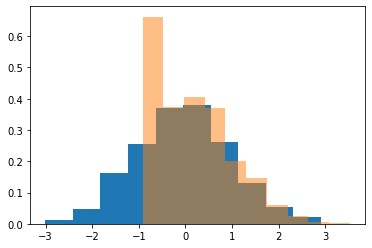

In [ ]:
import matplotlib.pyplot as plt
plt.hist(samples_simpleGG[:,0],density=True)
plt.hist(X_train[:,0].numpy(), alpha=0.5, density=True)

In [ ]:
# assess sample quality

def W2(x,y):
    return torch.sqrt(ot.emd2(torch.ones(x.shape[0])/x.shape[0], torch.ones(y.shape[0])/y.shape[0], ot.dist(x, y)))

print(W2(X_test.reshape(-1,MAGIC_data.shape[1]).float(),torch.tensor(samples_simpleGG).float()),'GG+Netratio 100hmc') 
print(W2(X_test.reshape(-1,MAGIC_data.shape[1]).float(),X_train.reshape(-1,MAGIC_data.shape[1]).float()[:50]),'true obs')
print(W2(X_test.reshape(-1,MAGIC_data.shape[1]).float(),torch.tensor(scs.multivariate_normal.rvs(mean=np.zeros(MAGIC_data.shape[1]), cov=GG_cov, size=500)).float()[:50]),'gaussian')
print(W2(X_test.reshape(-1,MAGIC_data.shape[1]).float(),torch.randn(500,MAGIC_data.shape[1]).float()[:50]),'random')

print((n_indep,seed,train_ratio_model))

print('Time:', time.time()-start)
#tensor(3.6378) GG+Netratio 100hmc


tensor(3.6722) GG+Netratio 100hmc
tensor(1.7372) true obs
tensor(2.5366) gaussian
tensor(3.9858) random
(10, 990109, True)
Time: 926.5143253803253


### IGC vine and Gaussian

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.distributions as dist
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torchsummary import summary
import numpy as np
import scipy.stats as scs
from statsmodels.distributions.empirical_distribution import ECDF
import time
import ot
from pyhmc import hmc
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as scs
from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
import pyvinecopulib as pv
import pandas as pd


In [74]:
def loss_nce(r_p, r_q,p_size, q_size):
    v = q_size / p_size
    return (-(r_p /(v+r_p)).log()).mean() - v* ((v/(v+r_q)).log().mean()) 

def W2(x,y):
    return torch.sqrt(ot.emd2(torch.ones(x.shape[0])/x.shape[0], torch.ones(y.shape[0])/y.shape[0], ot.dist(x, y)))


In [5]:
U = scs.norm.cdf(X_train.reshape(-1,28*28))
U_test = scs.norm.cdf(X_test.reshape(-1,28*28))

In [76]:

class SoftRank(nn.Module):
    """Differentiable ranking layer"""
    def __init__(self, alpha=1000.0):
        super(SoftRank, self).__init__()
        self.alpha = alpha # constant for scaling the sigmoid to approximate sign function, larger values ensure better ranking, overflow is handled properly by PyTorch

    def forward(self, inputs):
        # input is a ?xSxD tensor, we wish to rank the S samples in each dimension per each batch
        # output is  ?xSxD tensor where for each dimension the entries are (rank-0.5)/N_rank
        x = inputs.unsqueeze(-1) #(?,S,D) -> (?,S,D,1)
        x_2 = x.repeat(1, 1, 1, x.shape[1]) # (?,S,D,1) -> (?,S,D,S) (samples are repeated along axis 3, i.e. the last axis)
        x_1 = x_2.transpose(1, 3) #  (?,S,D,S) -> (?,S,D,S) (samples are repeated along axis 1)
        return torch.transpose(torch.sum(torch.sigmoid(self.alpha*(x_1-x_2)), dim=1), 1, 2)/(torch.tensor(x.shape[1], dtype=torch.float32))


class IGC(nn.Module):
    
    def __init__(self, hidden_size=100, layers_number=2, output_size=2):
        super(IGC, self).__init__()
        self.dim_latent = 3 * output_size
        self.hidden_size = hidden_size
        self.layers_nuber = layers_number
        self.output_size = output_size
        self.linear_in = nn.Linear(in_features=self.dim_latent, out_features=self.hidden_size) 
        self.linear = nn.Linear(in_features=self.hidden_size, out_features=self.hidden_size)
        self.linear_out = nn.Linear(in_features=self.hidden_size, out_features=self.output_size)
        self.marginal_cdfs = None
        self.ecdf_10e6_samples = None

    def forward_train(self, z):
        '''
        Input noise z with shape (M,dim_latent)\\
        Outputs (u,v) pairs with shape (M,output_size=2), while ensuring u and v each have uniform marginals.
        '''
        y = torch.relu(self.linear_in(z))
        for layer in range(self.layers_nuber):
            y = torch.relu(self.linear(y))
        y = self.linear_out(y).unsqueeze(0)
        u = SoftRank()(y).squeeze(0)
        return u
        
    def Energy_Score_pytorch(self,beta, observations_y, simulations_Y):
        n = len(observations_y)
        m = len(simulations_Y)

        # First part |Y-y|. Gives the L2 dist scaled by power beta. Is a vector of length n/one value per location.
        diff_Y_y = torch.pow(
            torch.norm(
                (observations_y.unsqueeze(1) -
                simulations_Y.unsqueeze(0)).float(),
                dim=2,keepdim=True).reshape(-1,1),
            beta)

        # Second part |Y-Y'|. 2* because pdist counts only once.
        diff_Y_Y = 2 * torch.pow(
            nn.functional.pdist(simulations_Y),
            beta)
        Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
        return Energy


    def forward(self, n_samples):
        ''' 
        Function to sample from the copula, once training is done.

        Input: n_samples - number of samples to generate
        Output: torch.tensor of shape (n_samples, output_size) on copula space.
        '''
        with torch.no_grad():
            if self.marginal_cdfs is None:
                self.marginal_cdfs = []
                # sample 10^6 points from the latent space and compute empirical marginal cdfs
                z = torch.randn(10**6, self.dim_latent)
                y = torch.relu(self.linear_in(z))
                for layer in range(self.layers_nuber):
                    y = torch.relu(self.linear(y))
                y = self.linear_out(y) # samples used to approximate cdfs
                for dim in range(y.shape[1]):
                    ecdf = ECDF(y[:, dim].numpy())
                    self.marginal_cdfs.append(ecdf)
                self.ecdf_10e6_samples = y
            # sample the latent space and apply ecdfs
            z = torch.randn(n_samples, self.dim_latent)
            y = torch.relu(self.linear_in(z))
            for layer in range(self.layers_nuber):
                y = torch.relu(self.linear(y))
            y = self.linear_out(y)
            for dim in range(y.shape[1]):
                y[:, dim] = torch.tensor(self.marginal_cdfs[dim](y[:, dim].numpy()), dtype=torch.float32)
            return y


In [78]:

# make training data on 0-1 scale
X_train_cop = torch.tensor(scs.norm.cdf(X_train.reshape(-1,MAGIC_data.shape[1])),dtype=torch.float32).clip(1e-5,1-1e-5)

# training loop
igc_cop = IGC(hidden_size=100, layers_number=2, output_size=MAGIC_data.shape[1])

u_obs = X_train_cop

optimizer = torch.optim.Adam(igc_cop.parameters())
loss_hist = []

for i in tqdm(range(501)):
    optimizer.zero_grad()
    u = igc_cop.forward_train(torch.randn((200, igc_cop.dim_latent)))
    loss = igc_cop.Energy_Score_pytorch(1, u_obs[np.random.choice(range(u_obs.shape[0]),100,replace=True)], u)
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.item())

# save the model
torch.save(igc_cop.state_dict(), f'igc_cop{seed}.pth')
# sample
samples_cdf = igc_cop.forward(500).detach().numpy()
# save the samples
np.save(f'samples_igc{seed}.npy',samples_cdf)
print((W2(X_test.reshape(-1,MAGIC_data.shape[1]).float(),torch.tensor(scs.norm.ppf(samples_cdf)).float(),),'IGC'))


100%|██████████| 501/501 [00:09<00:00, 51.63it/s]


(tensor(2.5120), 'IGC')


In [80]:
print((W2(X_test.reshape(-1,MAGIC_data.shape[1]).float(),torch.tensor(samples_simpleGG).float(),),'GG Ratio'))


(tensor(4.0214), 'GG Ratio')


In [85]:
U = scs.norm.cdf(X_train.reshape(-1,MAGIC_data.shape[1]))
U_test = scs.norm.cdf(X_test.reshape(-1,MAGIC_data.shape[1]))




start = time.time()
controls = pv.FitControlsVinecop(family_set=[pv.BicopFamily.tll],
                                                selection_criterion='mbic',
                                                nonparametric_method='constant', #KDE-copula
                                                nonparametric_mult=10,
                                                #trunc_lvl=5,
                                                #threshold=0.05, # truntrunc_lvl=5,threshold=0.05 30K mnist -> 33mins train/sample/evals
                                                num_threads = 8) # bandwidth
cop = pv.Vinecop(U, controls=controls)
print('fitted',time.time()-start)

time2 = time.time()
cop_sample = cop.simulate(25)
print('sims', time.time()-time2)

time3 = time.time()
cop_logpdf = cop.loglik(U_test)
print('-logpdf', time.time()-time3)
print(cop_logpdf/U_test.shape[0])

fitted 25.216372966766357
sims 0.09964489936828613
-logpdf 0.7309033870697021
8.25050387998016
-logpdf 0.7309033870697021
8.25050387998016


In [86]:
cop_sample_norm = scs.norm.ppf(cop_sample)

W2(X_test.reshape(-1,MAGIC_data.shape[1]).float(),torch.tensor(cop_sample_norm).reshape(-1,MAGIC_data.shape[1]).float())

tensor(2.7402)